In [1]:
# ! pip install -qq func-adl-servicex~=1.0.2
# ! pip install -qq --upgrade git+https://github.com/matthewfeickert/heputils.git

In [2]:
from servicex import ServiceXDataset
from func_adl_servicex import ServiceXSourceXAOD

import numpy as np
import matplotlib.pyplot as plt
import mplhep
import heputils

mplhep.set_style("ATLAS")

Get keys for authentication

In [3]:
# from google.colab import drive

# drive.mount("/content/drive")
# !cp "/content/drive/My Drive/atlas-servicex.yaml" ./.servicex

Perform a query

In [4]:
jet_moments = [
    "LArQuality",
    "LArBadHVEnergyFrac",
    "HECQuality",
    "EMFrac",
    "FracSamplingMax",
    "HECFrac",
    "NegativeE",
    "Timing",
]

select_statement = (
    "lambda j: ("
    + ", ".join([f'j.getAttributeFloat("{x}")' for x in jet_moments])
    + ")"
)
print(select_statement)

lambda j: (j.getAttributeFloat("LArQuality"), j.getAttributeFloat("LArBadHVEnergyFrac"), j.getAttributeFloat("HECQuality"), j.getAttributeFloat("EMFrac"), j.getAttributeFloat("FracSamplingMax"), j.getAttributeFloat("HECFrac"), j.getAttributeFloat("NegativeE"), j.getAttributeFloat("Timing"))


In [5]:
did = "mc16_13TeV:mc16_13TeV.364700.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ0WithSW.deriv.DAOD_JETM1.e7142_s3126_r9364_p4128"

dataset = ServiceXDataset(did, max_workers=200, backend_type="xaod")

query = (
    ServiceXSourceXAOD(dataset)
    .SelectMany('lambda e: e.Jets("AntiKt4EMTopoJets")')
    .Where("lambda j: j.pt()/1000>20 and abs(j.eta())<4.5")
    .Select(select_statement)
    .AsPandasDF(tuple(jet_moments))
    .value()
)

query.head()
# query.to_csv("query_results.csv")
# query.to_hdf("query_results.hdf5")

In [20]:
def quick_plot(hist, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # get kwargs
    label = kwargs.pop("label", None)
    is_density = kwargs.pop("density", True)
    xlabel = kwargs.pop("xlabel", None)
    ylabel = kwargs.pop("ylabel", None)
    logy = kwargs.pop("logy", True)

    mplhep.histplot(hist, label=label, density=is_density, ax=ax)

    if logy:
        ax.semilogy()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if label is not None:
        ax.legend(loc="best")

    return ax

Make a first plot:

**Avg LArQ** (LArQuality): The energy-squared weighted average of the LArQ of all cells in a jet

In [18]:
bin_width = 0.05
_range = [-0.2, 2.6]
_bins = int((_range[1] - _range[0]) / bin_width)

jet_hists = [
    heputils.convert.numpy_to_hist(*np.histogram(getattr(query, moment), bins=_bins))
    for moment in jet_moments
]

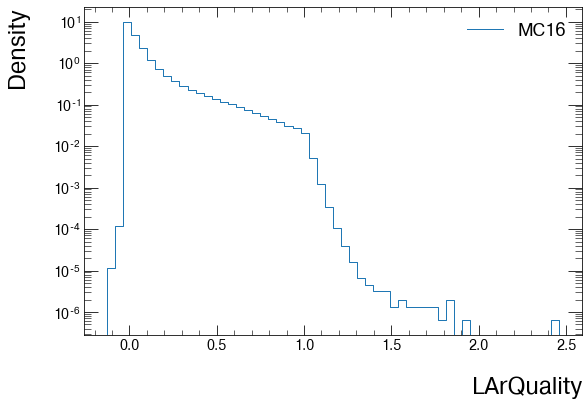

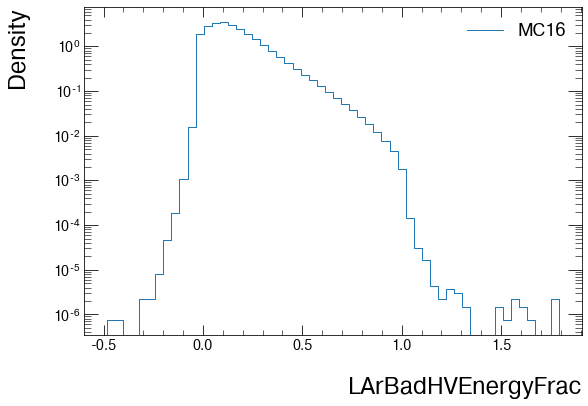

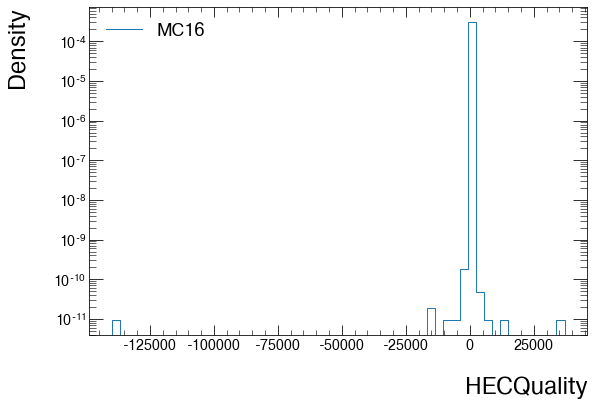

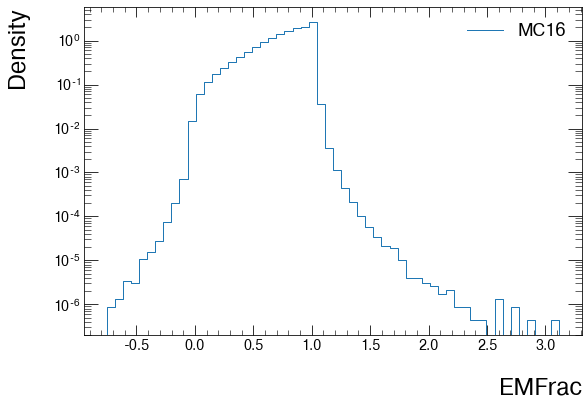

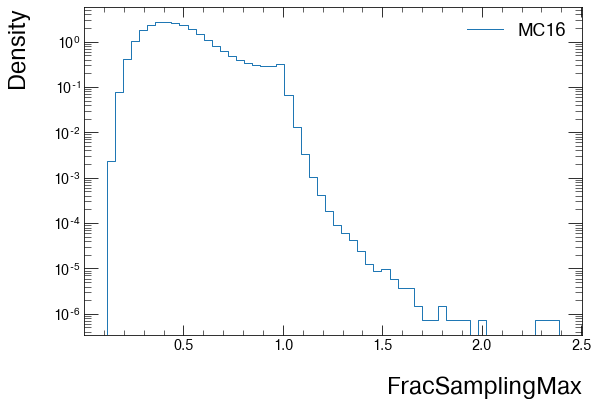

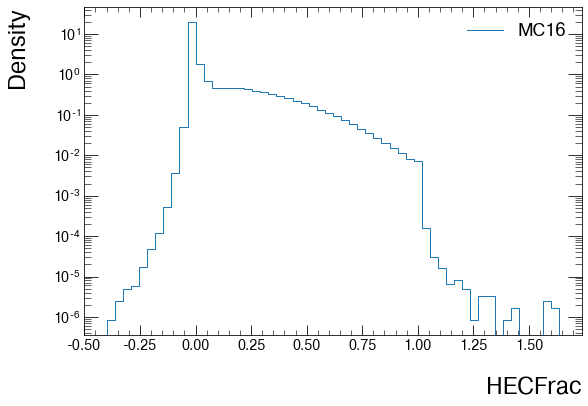

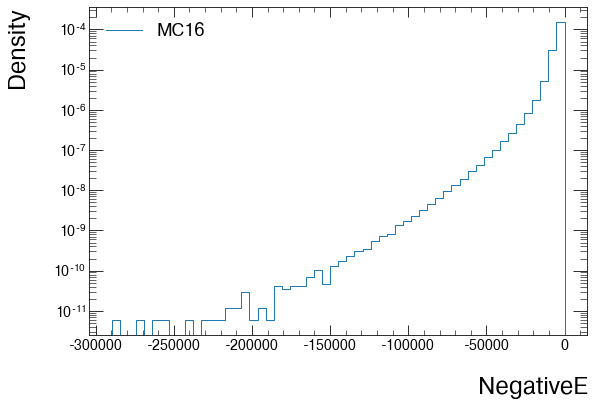

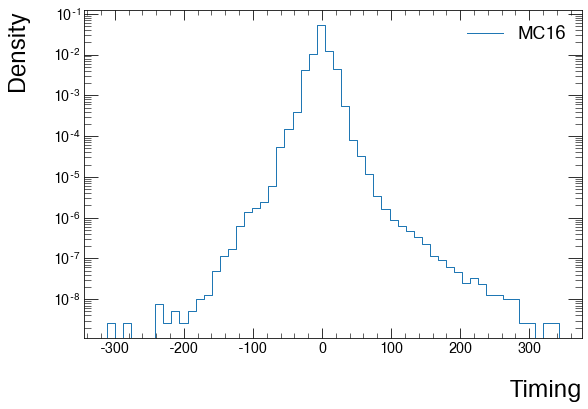

In [22]:
for hist, label in zip(jet_hists, jet_moments):
    fig, ax = plt.subplots()
    quick_plot(
        hist,
        xlabel=label,
        ylabel="Density",
        label="MC16",
        density=True,
        ax=ax,
    )